<a href="https://colab.research.google.com/github/martin-dj/casa0018/blob/main/Week7/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

First set up the necessary Python imports and set up Tensor Board which provides a visual output of the training process.

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Load the TensorBoard notebook extension
#%load_ext tensorboard
%reload_ext tensorboard


# Clear any logs from previous runs
%rm -rf ./logs/

# Create Data

Create sine function data. We’ll use the NumPy linspace to generate x values ranging between 0 and 200*Pi (100 cycles) and NumPy sine function to generate sine values to the corresponding x. We subdivide the range into 1000 data points. We also add a linear componenent to the sine data to generate a trend.

We then add some noise to the data. Finally, we visualize the data.

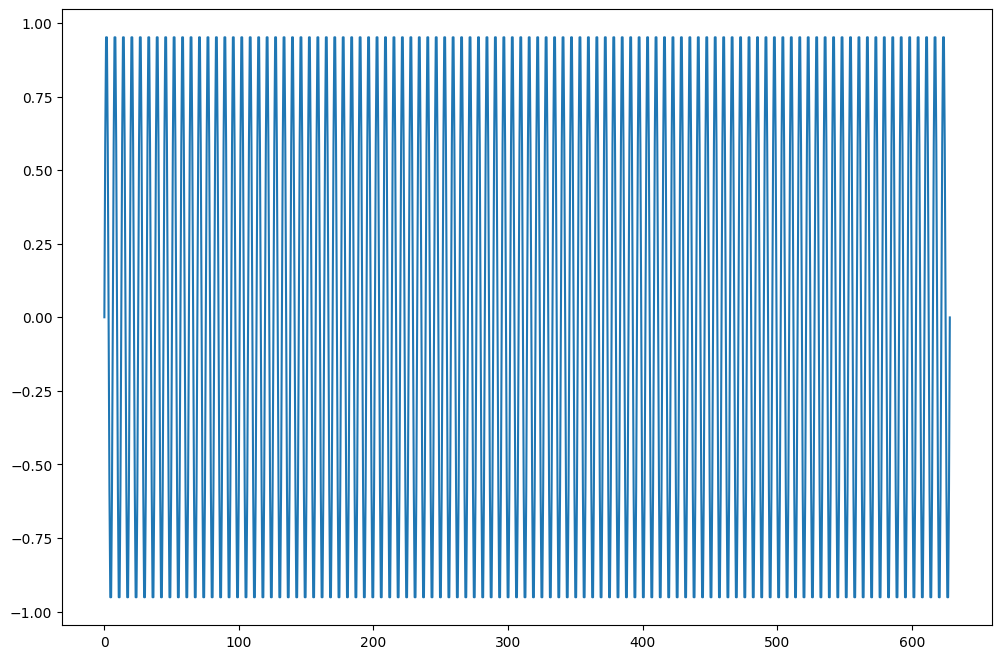

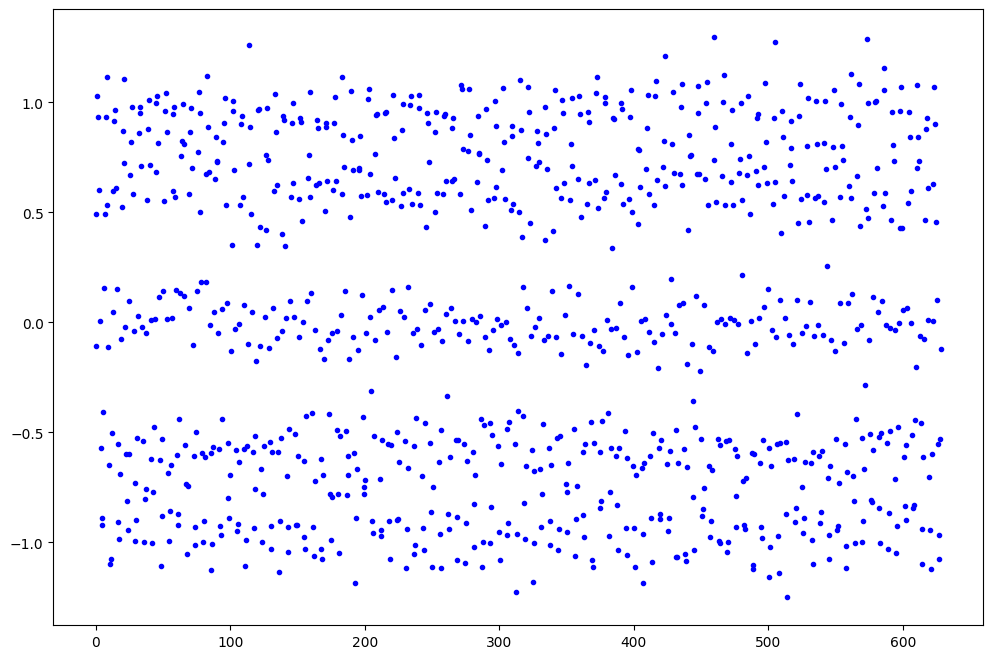

In [20]:
x = np.linspace(0, 200*3.14159, 1001) # in radians, 100 cycles, 10 data points per cycle
#y = np.sin(x) + 0.002*x
y = np.sin(x)

# Plot our data
plt.figure(figsize=(12,8))
plt.plot(x,y)
plt.show()

y += 0.1*np.random.randn(*y.shape) #Add some noise to the data to make it more realistic

# Plot our data
plt.figure(figsize=(12,8))
plt.plot(x, y, 'b.')
plt.show()

# Define a dataframe using x and y values.
df = pd.DataFrame(data=y,index=x,columns=['Sine'])


# Split Data
Split the data into train and validate subsets. The train dataset is used for training the model and the validate data set is used to validate the model against unseen data as it undergoes training. Normally there is a third unseen data set used for testing the trained model. However, the time series used here is sufficiently predictable to test 'by eye'.

First, we’ll check the length of the data frame and use a fraction of the data to validate our model. Now if we multiply the length of the data frame with val_percent and round the value (as we are using for indexing purpose) we’ll get the index position i.e., val_index. Last, we’ll split the train and validation data using the val_index.

1001
801
200


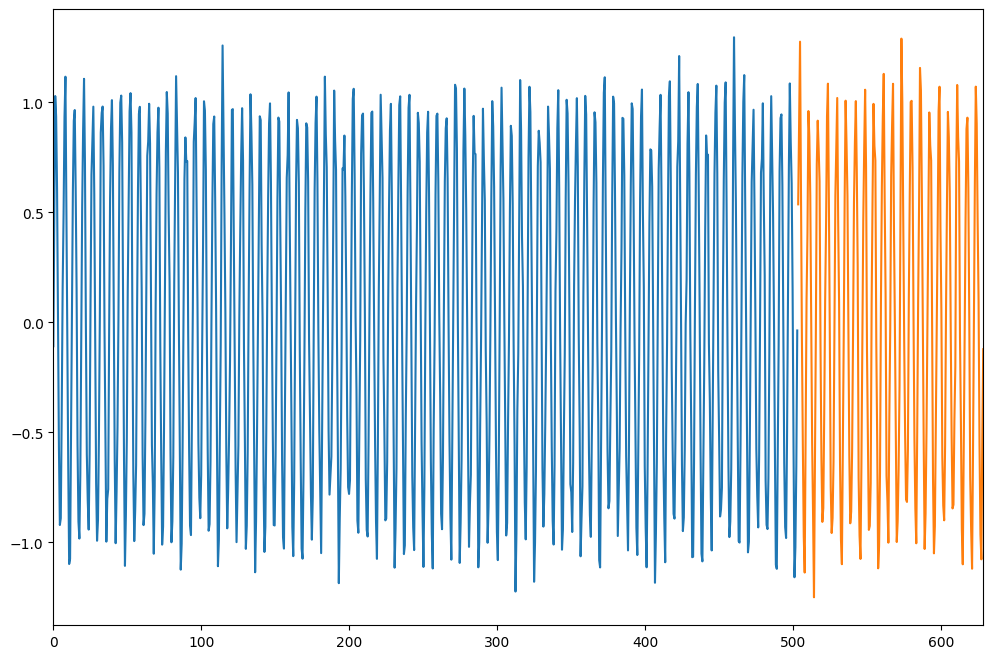

In [21]:
val_pecent = 0.2
len(df)*val_pecent
val_point = np.round(len(df)*val_pecent)
val_index = int(len(df) - val_point)
train = df.iloc[:val_index]
val = df.iloc[val_index:]

plt.figure(figsize=(12,8))
plt.xlim(0, 200*3.142)

print(len(df)) # 601
print(len(train))
print(len(val))

plt.plot(train)
plt.plot(val)


# Normalise
We need to normalise the data in the range 0-1. We use a scaler to determine the max and min of the complete data set and then use the scaler to scale both the training a validation data set

In [22]:
scaler = MinMaxScaler()
scaler.fit(df)
MinMaxScaler(copy=True, feature_range=(0, 1))
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)

NameError: name 'MinMaxScaler' is not defined

# Time Series Generator
One problem we’ll face when using time series data is, we must transform the data into sequences of samples with input data and target data before feeding it into the model. We should select the length of the data sequence (window length) in such a way so that the model has an adequate amount of input data to generalize and predict i.e. in this situation we must feed the model at least with one cycle of sine wave values.

The model takes the previous 20 data points (one window) as input data and uses it to predict the next point, which is then compared to the actual target value for backpropagation and gradient descent.

This process is time-consuming and difficult if we perform this manually, hence we’ll make use of the Keras Timeseries Generator which transforms the data automatically and ready to train models without heavy lifting.

We can see that the length of the scaled_train is 801 and the length of the generator is 41(801–20) i.e. if we perform the tuple unpacking of the generator function using X,y as variables, X comprises the 20 data points (training window) and y contains the 21st data point which the model uses for the prediction target. i.e. X0 = values at timesteps 0-19 and y0 = value at timestep 20; X1 = values at timesteps 1-20 and y1 = value at timestep 21; ... X781 = values at timesteps 781-800 and y781 = value at timestep 801.

We also create a validation_generator that operates on the validation data set (scaled_val in the code). The validator_generator is not used to train the model. Instead, it is used after each epoch to validate how well the current model fits an **unseen** data set.

The batch size indicates how many sequences (windows) are seen by the network before the network weights are updated. A batch size of 1 means the weights are updated after every sequence (window) is input to the network. In this case a batch size of 10 is used, which speeds up training.

An epoch is one complete pass through the training data set.

In [ ]:
length = 20 # sequence length - the length of the training window
batch_size = 10

# Using timeseries_dataset_from_array to create a generator
generator = timeseries_dataset_from_array(data=scaled_train, targets=scaled_train, sequence_length=length, batch_size=batch_size)

validation_generator = timeseries_dataset_from_array(scaled_val, scaled_val, sequence_length=length, batch_size=batch_size)

print(len(scaled_train)) # 801
# the generator object has no length attribute
# it is possible to determine the length, but this is more involved
# the below code will demonstrate how to find the length if required
print(len(list(generator.as_numpy_iterator())))

# Create a model

The code to create a LSTM is similar to that for earlier NNs you have already seen.

The variable (n_features) defined stands for the number of features in the training data i.e., as we are dealing with univariate data we’ll only have one feature whereas if we are using multivariate data containing multiple features then we must specify the count of features in our data.

In [ ]:
n_features = 1

# Encoder
encoder = Sequential()
encoder.add(LSTM(length, return_sequences=True, input_shape=(length, n_features)))

# Decoder
decoder = Sequential()
decoder.add(LSTM(length, return_sequences=False, input_shape=(length, length))) # Pass the output shape of the encoder
decoder.add(Dense(1))

# Autoencoder
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

In [ ]:
autoencoder.fit(generator, epochs=20, validation_data=validation_generator)

# Comparing Forecasts Using The Validation Data

Now let's compare the forecasts of the LSTM model using our validation data set.

Again remembering this is not a true test as the validation set was used to validate our models.

Before we plot the results we reverse the scaling transformations.

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape(1, length, n_features)


for i in range(len(val)):
  current_pred = autoencoder.predict(current_batch)[0]

  test_predictions.append(current_pred)

  # The issue was with the slicing of current_batch[:,1:,1:] which results in an
  # array with shape (1, 19, 0) along dimension 2. We need to keep the dimension 2
  # to be 1 in order to append the new prediction which has shape (1,1).
  # Instead of current_batch[:,1:,1:], we should use current_batch[:,1:,:] to select
  # all rows, columns from index 1 onwards, and all elements along the third dimension
  # This results in the correct shape (1, 19, 1) allowing the append to happen without error.
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1) # Changed this line to fix the dimensional error

true_predictions = scaler.inverse_transform(test_predictions)
val['LSTM Predictions'] = true_predictions
val.plot(figsize=(12,8))

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 50, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, 20, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_12 (LSTM)            │ [(None, 64), (None,    │         16,896 │ input_layer_7[0][0]    │
│                           │ 64), (None, 64)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_13 (LSTM)            │ [(None, 20, 64),       │         16,896 │ input_layer_8[0][0],   │
│                           │ (None, 64), (None,     │                │ lstm_12[0][1],         │
│                           │ 64)]                   │                │ lstm_12[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 20, 1)          │             65 │ lstm_13[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,857 (132.25 KB)

 Trainable params: 33,857 (132.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.4597 - val_loss: 0.0131
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0069 - val_loss: 5.4616e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.3403e-04 - val_loss: 2.0209e-04
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7329e-04 - val_loss: 1.0365e-04
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.7563e-05 - val_loss: 7.4983e-05
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.1872e-05 - val_loss: 6.1026e-05
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.1903e-05 - val_loss: 6.7905e-05
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.3496e-05 - val_loss: 4.2467e-05
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7269e-05 - val_loss: 4.4117e-05
Epoch 10/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.2481e-05 - val_loss: 4.4042e-05
Epoch 11/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.7238e-05 - val_loss

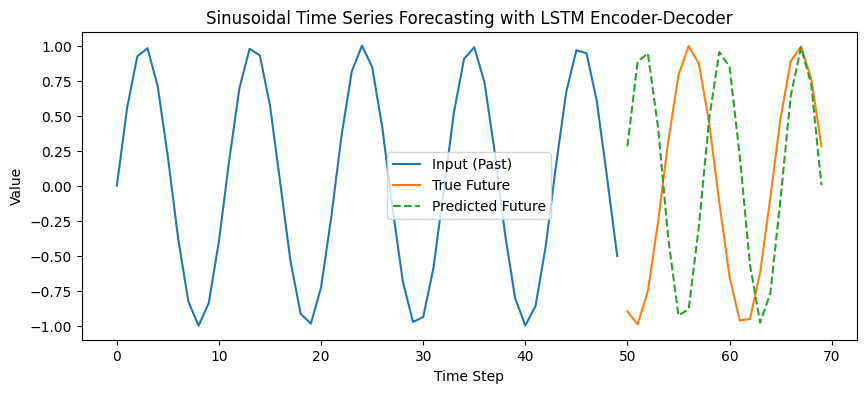

In [54]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt

# ==== Generate Sinusoidal Data ====
def generate_sinusoidal_data(samples=1000, time_steps_in=50, time_steps_out=20, frequency=0.1, noise=0.0):
    """Generates sinusoidal time series data for training"""
    X, y = [], []
    t = np.linspace(0, samples * frequency, samples + time_steps_in + time_steps_out)
    data = np.sin(2 * np.pi * t) + noise * np.random.randn(len(t))  # Sin wave with noise

    for i in range(samples):
        X.append(data[i : i + time_steps_in])  # Past values
        y.append(data[i + time_steps_in : i + time_steps_in + time_steps_out])  # Future values

    X = np.array(X).reshape(samples, time_steps_in, 1)  # Reshape for LSTM
    y = np.array(y).reshape(samples, time_steps_out, 1)  # Reshape for LSTM
    return X, y

# Generate Data
time_steps_in = 50  # Number of past time steps
time_steps_out = 20  # Number of future steps to predict
num_samples = 1000
X, y = generate_sinusoidal_data(num_samples, time_steps_in, time_steps_out)

# ==== Encoder-Decoder Model ====
latent_dim = 64  # LSTM units

# Encoder
encoder_inputs = Input(shape=(time_steps_in, 1))
encoder_lstm = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]  # Context vector

# Decoder
decoder_inputs = Input(shape=(time_steps_out, 1))  # Input: Zeros during training
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1)  # Predict next step value
decoder_outputs = decoder_dense(decoder_outputs)

# Define model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="mse")
model.summary()

# ==== Train Model ====
decoder_input_data = np.zeros_like(y)  # Zero padding during training (teacher forcing)
model.fit([X, decoder_input_data], y, batch_size=16, epochs=30, validation_split=0.1)

# ==== Inference (Prediction) ====
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Function to make predictions
def predict_sequence(input_seq):
    """Generates a predicted sequence from the trained model"""
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, time_steps_out, 1))  # Start with zeros

    predictions = []

    for _ in range(time_steps_out):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        predictions.append(output_tokens[:, -1, 0])  # Get last timestep prediction
        target_seq[:, -1, 0] = output_tokens[:, -1, 0]  # Update input for next step

        states_value = [h, c]

    return np.array(predictions).flatten()

# ==== Example Prediction ====
test_input = X[0].reshape(1, time_steps_in, 1)  # Use the first training example
predicted_sequence = predict_sequence(test_input)

# ==== Plot Results ====
plt.figure(figsize=(10, 4))
plt.plot(range(time_steps_in), test_input.flatten(), label="Input (Past)")
plt.plot(range(time_steps_in, time_steps_in + time_steps_out), y[0].flatten(), label="True Future")
plt.plot(range(time_steps_in, time_steps_in + time_steps_out), predicted_sequence, label="Predicted Future", linestyle="dashed")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Sinusoidal Time Series Forecasting with LSTM Encoder-Decoder")
plt.show()


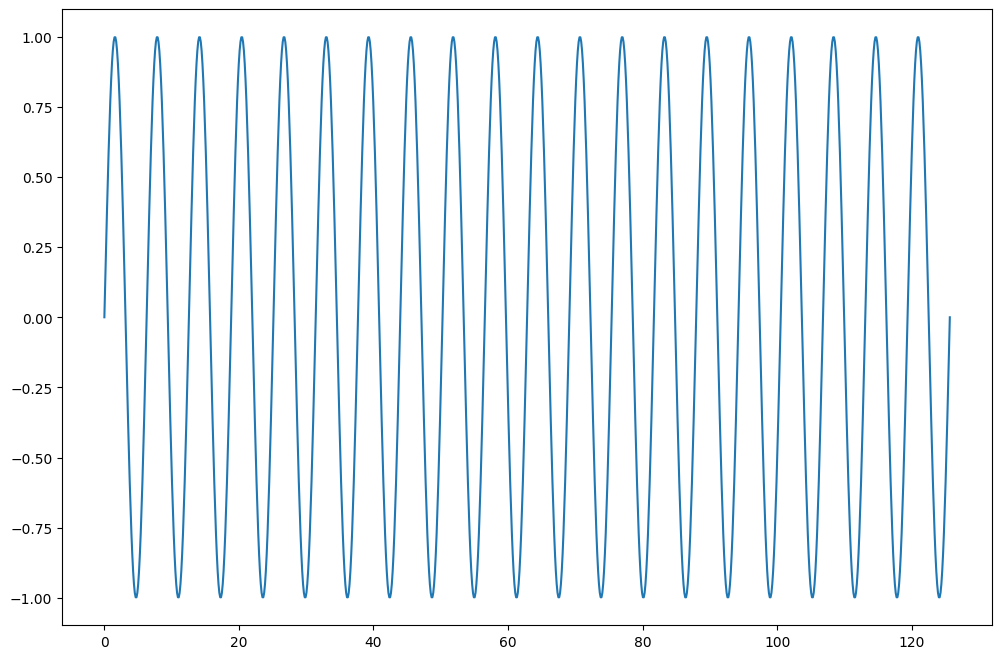

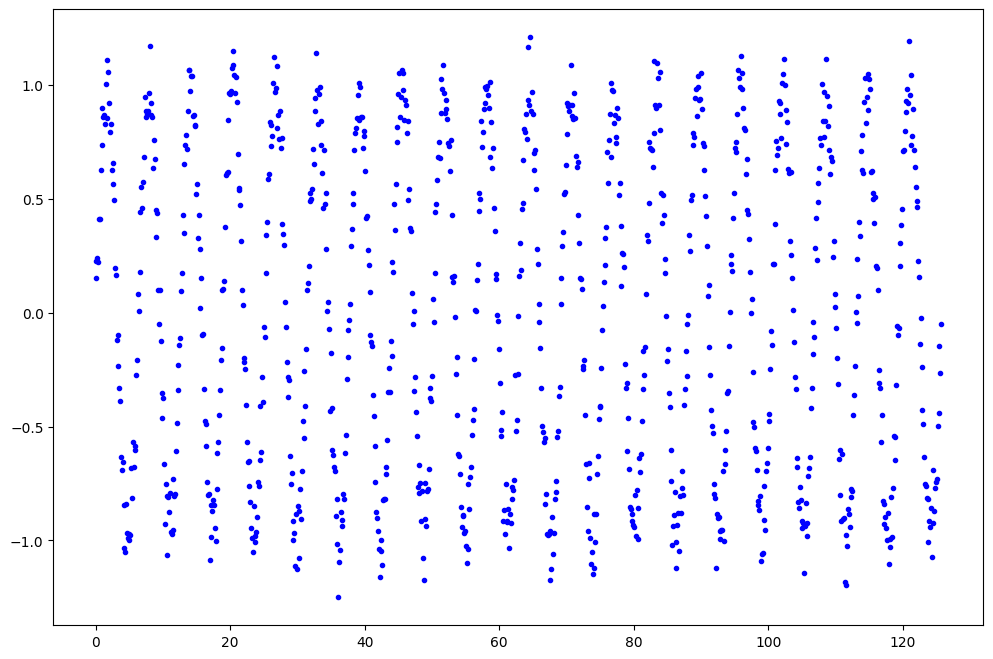

In [55]:
  import pandas as pd
  import numpy as np
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras.models import Model,Sequential
  from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, Dropout, TimeDistributed

  import matplotlib.pyplot as plt
  from sklearn.preprocessing import StandardScaler

  x_train, y_train = [], []
  TIME_STEPS = 20 #needs to be configured to the right jumps



  x = np.linspace(0, 20*2*np.pi, 1001) # in radians, 100 cycles, 10 data points per cycle
  #y = np.sin(x) + 0.002*x
  y = np.sin(x)

  # Plot our data
  plt.figure(figsize=(12,8))
  plt.plot(x,y)
  plt.show()

  y += 0.1*np.random.randn(*y.shape) #Add some noise to the data to make it more realistic

  # Plot our data
  plt.figure(figsize=(12,8))
  plt.plot(x, y, 'b.')
  plt.show()

  # Define a dataframe using x and y values.
  df = pd.DataFrame(data=y,index=x,columns=['Sine'])


1001
801
200


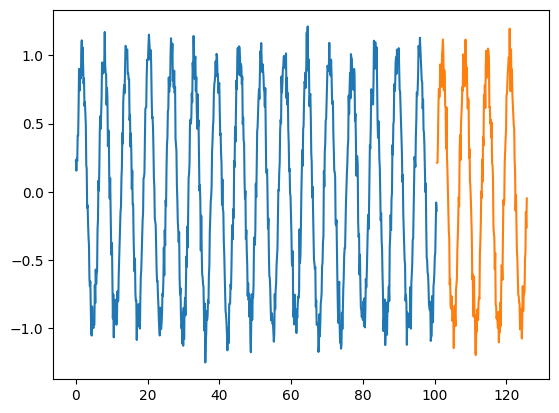

In [56]:
val_percent = 0.2
len(df)*val_percent
val_point = np.round(len(df)*val_percent)
val_index = int(len(df) - val_point)
train = df.iloc[:val_index]
val = df.iloc[val_index:]

train_x = x[: val_index]
test_x = x[val_index:]

print(len(df))
print(len(train))
print(len(val))

plt.plot(train)
plt.plot(val)

In [57]:
  scaler = StandardScaler()
  scaler.fit(train)
  train_y= scaler.transform(train)
  test_y= scaler.transform(val)



  def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


  x_train, y_train = create_dataset(train_x, train_y, TIME_STEPS)
  x_test, y_test = create_dataset(test_x, test_y, TIME_STEPS)


In [58]:
  sequence_length=20
  num_features=1
  model = Sequential()
  model.add(LSTM(units=20,input_shape=(sequence_length, num_features)))
  model.add(Dropout(rate=0.2))

  model.add(RepeatVector(sequence_length))
  model.add(LSTM(units=20,return_sequences=True))

  model.add(Dropout(rate=0.2))
  model.add(TimeDistributed(keras.layers.Dense(units=num_features)))

  model.compile(loss='mae', optimizer = tf.keras.optimizers.Adam())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [59]:
model.fit(x_train, y_train, epochs=50, batch_size=8)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 0.9083
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8842
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8886
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8985
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8956
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8712
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8870
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8841
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.8478
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8846
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8965
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8537
Epoch 13/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8734
Epoch 14/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8689
Epoch 15/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8485
Epoc

In [60]:
  x_train_pred = model.predict(x_train)
  # Reshape x_train_pred to match the dimensions of x_train
  x_train_pred = x_train_pred.reshape(x_train.shape)
  train_mse_loss=np.mean(np.abs(x_train_pred, x_train), axis=1)

  x_test_pred = model.predict(x_test)
  x_test_pred = x_test_pred.reshape(x_test.shape)
  test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
  THRESHOLD = np.percentile(test_mae_loss, 95)

  test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
  test_score_df['loss'] = test_mae_loss
  test_score_df['threshold'] = THRESHOLD
  test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
  test_score_df[col] = test[TIME_STEPS:][col]
  anomalies = test_score_df[test_score_df.anomaly == True]
  anomaly.append(test_score_df[test_score_df.anomaly == True])
  anomalies.head()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


NameError: name 'test' is not defined